In [205]:
import pandas as pd
import numpy as np
import json
from sklearn.utils import shuffle

In [206]:
file = open("F:\Code\HUST\Vietnamese-text-classification\content.json", encoding = 'utf8')

In [207]:
data = json.load(file)

In [208]:
df = pd.DataFrame(data)

In [209]:
df.head()

,id,author,content,crawled_at,picture_count,processed,source,title,topic,url,category
0,2,Lâm Thỏa,"*Việt Nam - Malaysia: 20h thứ Tư 8/6, trên VnE...",2022-06-07 14:05:51.433712,2,0,None,HLV Malaysia dọa ngáng đường Việt Nam,Thể thao,https://vnexpress.net/hlv-malaysia-doa-ngang-d...,0
1,3,Thanh Tâm,"""Các khu dân cư của thành phố Severodonetsk đã...",2022-06-07 14:05:51.797545,2,0,None,Nga tuyên bố 'giải phóng' hoàn toàn khu dân cư...,Thế giới,https://vnexpress.net/nga-tuyen-bo-giai-phong-...,1
2,4,Thảo Mi,"Ngày 7/6, phiên xử phúc thẩm ông Tất Thành Can...",2022-06-07 14:05:53.482540,2,0,None,Ông Tất Thành Cang được đề nghị giảm án,Pháp luật,https://vnexpress.net/ong-tat-thanh-cang-duoc-...,1
3,5,Quốc Thắng,"Chiều 7/6, Khoa bị Công an quận Phú Nhuận phối...",2022-06-07 14:05:53.848085,2,0,None,Nghi can sát hại cha bị bắt,Pháp luật,https://vnexpress.net/nghi-can-sat-hai-cha-bi-...,1
4,6,Vũ Hoàng,"Thủ tướng Anh Boris Johnson hôm 6/6 đã ""thoát ...",2022-06-07 14:05:54.226303,1,0,None,Sóng gió chờ đón Thủ tướng Anh hậu bỏ phiếu bấ...,Thế giới,https://vnexpress.net/thoat-hiem-bat-tin-nhiem...,1


In [210]:
print(df.shape)
df = shuffle(df)

(19411, 11)


In [211]:
columns = ['id', 'crawled_at', 'processed', 'source', 'topic']
df = df.drop(columns=columns)

In [212]:
print(df.shape)

(19411, 6)


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19411 entries, 7132 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         19411 non-null  object
 1   content        19411 non-null  object
 2   picture_count  19411 non-null  int64 
 3   title          19411 non-null  object
 4   url            19411 non-null  object
 5   category       19411 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


In [214]:
content_array = np.array(df['content'])

In [215]:
import re
import nltk

In [216]:
corpus = []

for i in range(0, 19410):
    newArr = re.sub('/([\u0041-\u005A\u0061-\u007A\u00AA\u00B5\u00BA\u00C0-\u00D6\u00D8-\u00F6\u00F8-\u02C1\u02C6-\u02D1\u02E0-\u02E4\u02EC\u02EE\u0370-\u0374\u0376\u0377\u037A-\u037D\u0386\u0388-\u038A\u038C\u038E-\u03A1\u03A3-\u03F5\u03F7-\u0481\u048A-\u0527\u0531-\u0556\u0559\u0561-\u0587\u05D0-\u05EA\u05F0-\u05F2\u0620-\u064A\u066E\u066F\u0671-\u06D3\u06D5\u06E5\u06E6\u06EE\u06EF\u06FA-\u06FC\u06FF\u0710\u0712-\u072F\u074D-\u07A5\u07B1\u07CA-\u07EA\u07F4\u07F5\u07FA\u0800-\u0815\u081A\u0824\u0828\u0840-\u0858\u08A0\u08A2-\u08AC\u0904-\u0939\u093D\u0950\u0958-\u0961\u0971-\u0977\u0979-\u097F\u0985-\u098C\u098F\u0990\u0993-\u09A8\u09AA-\u09B0\u09B2\u09B6-\u09B9\u09BD\u09CE\u09DC\u09DD\u09DF-\u09E1\u09F0\u09F1\u0A05-\u0A0A\u0A0F\u0A10\u0A13-\u0A28\u0A2A-\u0A30\u0A32\u0A33\u0A35\u0A36\u0A38\u0A39\u0A59-\u0A5C\u0A5E\u0A72-\u0A74\u0A85-\u0A8D\u0A8F-\u0A91\u0A93-\u0AA8\u0AAA-\u0AB0\u0AB2\u0AB3\u0AB5-\u0AB9\u0ABD\u0AD0\u0AE0\u0AE1\u0B05-\u0B0C\u0B0F\u0B10\u0B13-\u0B28\u0B2A-\u0B30\u0B32\u0B33\u0B35-\u0B39\u0B3D\u0B5C\u0B5D\u0B5F-\u0B61\u0B71\u0B83\u0B85-\u0B8A\u0B8E-\u0B90\u0B92-\u0B95\u0B99\u0B9A\u0B9C\u0B9E\u0B9F\u0BA3\u0BA4\u0BA8-\u0BAA\u0BAE-\u0BB9\u0BD0\u0C05-\u0C0C\u0C0E-\u0C10\u0C12-\u0C28\u0C2A-\u0C33\u0C35-\u0C39\u0C3D\u0C58\u0C59\u0C60\u0C61\u0C85-\u0C8C\u0C8E-\u0C90\u0C92-\u0CA8\u0CAA-\u0CB3\u0CB5-\u0CB9\u0CBD\u0CDE\u0CE0\u0CE1\u0CF1\u0CF2\u0D05-\u0D0C\u0D0E-\u0D10\u0D12-\u0D3A\u0D3D\u0D4E\u0D60\u0D61\u0D7A-\u0D7F\u0D85-\u0D96\u0D9A-\u0DB1\u0DB3-\u0DBB\u0DBD\u0DC0-\u0DC6\u0E01-\u0E30\u0E32\u0E33\u0E40-\u0E46\u0E81\u0E82\u0E84\u0E87\u0E88\u0E8A\u0E8D\u0E94-\u0E97\u0E99-\u0E9F\u0EA1-\u0EA3\u0EA5\u0EA7\u0EAA\u0EAB\u0EAD-\u0EB0\u0EB2\u0EB3\u0EBD\u0EC0-\u0EC4\u0EC6\u0EDC-\u0EDF\u0F00\u0F40-\u0F47\u0F49-\u0F6C\u0F88-\u0F8C\u1000-\u102A\u103F\u1050-\u1055\u105A-\u105D\u1061\u1065\u1066\u106E-\u1070\u1075-\u1081\u108E\u10A0-\u10C5\u10C7\u10CD\u10D0-\u10FA\u10FC-\u1248\u124A-\u124D\u1250-\u1256\u1258\u125A-\u125D\u1260-\u1288\u128A-\u128D\u1290-\u12B0\u12B2-\u12B5\u12B8-\u12BE\u12C0\u12C2-\u12C5\u12C8-\u12D6\u12D8-\u1310\u1312-\u1315\u1318-\u135A\u1380-\u138F\u13A0-\u13F4\u1401-\u166C\u166F-\u167F\u1681-\u169A\u16A0-\u16EA\u1700-\u170C\u170E-\u1711\u1720-\u1731\u1740-\u1751\u1760-\u176C\u176E-\u1770\u1780-\u17B3\u17D7\u17DC\u1820-\u1877\u1880-\u18A8\u18AA\u18B0-\u18F5\u1900-\u191C\u1950-\u196D\u1970-\u1974\u1980-\u19AB\u19C1-\u19C7\u1A00-\u1A16\u1A20-\u1A54\u1AA7\u1B05-\u1B33\u1B45-\u1B4B\u1B83-\u1BA0\u1BAE\u1BAF\u1BBA-\u1BE5\u1C00-\u1C23\u1C4D-\u1C4F\u1C5A-\u1C7D\u1CE9-\u1CEC\u1CEE-\u1CF1\u1CF5\u1CF6\u1D00-\u1DBF\u1E00-\u1F15\u1F18-\u1F1D\u1F20-\u1F45\u1F48-\u1F4D\u1F50-\u1F57\u1F59\u1F5B\u1F5D\u1F5F-\u1F7D\u1F80-\u1FB4\u1FB6-\u1FBC\u1FBE\u1FC2-\u1FC4\u1FC6-\u1FCC\u1FD0-\u1FD3\u1FD6-\u1FDB\u1FE0-\u1FEC\u1FF2-\u1FF4\u1FF6-\u1FFC\u2071\u207F\u2090-\u209C\u2102\u2107\u210A-\u2113\u2115\u2119-\u211D\u2124\u2126\u2128\u212A-\u212D\u212F-\u2139\u213C-\u213F\u2145-\u2149\u214E\u2183\u2184\u2C00-\u2C2E\u2C30-\u2C5E\u2C60-\u2CE4\u2CEB-\u2CEE\u2CF2\u2CF3\u2D00-\u2D25\u2D27\u2D2D\u2D30-\u2D67\u2D6F\u2D80-\u2D96\u2DA0-\u2DA6\u2DA8-\u2DAE\u2DB0-\u2DB6\u2DB8-\u2DBE\u2DC0-\u2DC6\u2DC8-\u2DCE\u2DD0-\u2DD6\u2DD8-\u2DDE\u2E2F\u3005\u3006\u3031-\u3035\u303B\u303C\u3041-\u3096\u309D-\u309F\u30A1-\u30FA\u30FC-\u30FF\u3105-\u312D\u3131-\u318E\u31A0-\u31BA\u31F0-\u31FF\u3400-\u4DB5\u4E00-\u9FCC\uA000-\uA48C\uA4D0-\uA4FD\uA500-\uA60C\uA610-\uA61F\uA62A\uA62B\uA640-\uA66E\uA67F-\uA697\uA6A0-\uA6E5\uA717-\uA71F\uA722-\uA788\uA78B-\uA78E\uA790-\uA793\uA7A0-\uA7AA\uA7F8-\uA801\uA803-\uA805\uA807-\uA80A\uA80C-\uA822\uA840-\uA873\uA882-\uA8B3\uA8F2-\uA8F7\uA8FB\uA90A-\uA925\uA930-\uA946\uA960-\uA97C\uA984-\uA9B2\uA9CF\uAA00-\uAA28\uAA40-\uAA42\uAA44-\uAA4B\uAA60-\uAA76\uAA7A\uAA80-\uAAAF\uAAB1\uAAB5\uAAB6\uAAB9-\uAABD\uAAC0\uAAC2\uAADB-\uAADD\uAAE0-\uAAEA\uAAF2-\uAAF4\uAB01-\uAB06\uAB09-\uAB0E\uAB11-\uAB16\uAB20-\uAB26\uAB28-\uAB2E\uABC0-\uABE2\uAC00-\uD7A3\uD7B0-\uD7C6\uD7CB-\uD7FB\uF900-\uFA6D\uFA70-\uFAD9\uFB00-\uFB06\uFB13-\uFB17\uFB1D\uFB1F-\uFB28\uFB2A-\uFB36\uFB38-\uFB3C\uFB3E\uFB40\uFB41\uFB43\uFB44\uFB46-\uFBB1\uFBD3-\uFD3D\uFD50-\uFD8F\uFD92-\uFDC7\uFDF0-\uFDFB\uFE70-\uFE74\uFE76-\uFEFC\uFF21-\uFF3A\uFF41-\uFF5A\uFF66-\uFFBE\uFFC2-\uFFC7\uFFCA-\uFFCF\uFFD2-\uFFD7\uFFDA-\uFFDC]+)/g', ' ', content_array[i])
    newArr = newArr.lower()
    if i == 0:
        print(newArr)
    newArr = newArr.split()
    newArr = ' '.join(newArr)
    corpus.append(newArr)
    

với sự góp mặt của loạt ca sĩ hàng đầu việt nam như hà trần, uyên linh, lệ quyên, lê hiếu…, chuỗi show âm nhạc soul of the forest hứa hẹn sẽ mang tới trải nghiệm âm nhạc độc đáo, cao cấp, hòa hợp với thiên nhiên, lần đầu tiên xuất hiện tại miền bắc. ngày 10/6, ca sĩ hà trần và uyên linh, hai giọng ca xuất sắc thuộc trường phái thực lực, sẽ là những người mở màn cho chuỗi sự kiện âm nhạc soul of the forest. đúng như tên gọi đậm chất thơ, soul of the forest được tổ chức giữa rừng thông, trong khuôn viên flamingo đại lải resort - top 10 resort đẹp nhất thế giới. chương trình do flamingo group phối hợp cùng the bros entertainment tổ chức sẽ mang đến chuỗi đêm nhạc đa dạng về chủ đề và sắc thái, nhưng có điểm chung nổi bật là âm nhạc thăng hoa giữa thiên nhiên. tiếp nối hà trần và uyên linh, ở những show tiếp theo, khán giả sẽ được gặp gỡ những danh ca hàng đầu của việt nam như: bằng kiều, đức trí, nguyên hà, lê hiếu, phan mạnh quỳnh, văn mai hương, lệ quyên…. trong một thời đại bùng nổ nhạ

In [217]:
corpus[0]

'với sự góp mặt của loạt ca sĩ hàng đầu việt nam như hà trần, uyên linh, lệ quyên, lê hiếu…, chuỗi show âm nhạc soul of the forest hứa hẹn sẽ mang tới trải nghiệm âm nhạc độc đáo, cao cấp, hòa hợp với thiên nhiên, lần đầu tiên xuất hiện tại miền bắc. ngày 10/6, ca sĩ hà trần và uyên linh, hai giọng ca xuất sắc thuộc trường phái thực lực, sẽ là những người mở màn cho chuỗi sự kiện âm nhạc soul of the forest. đúng như tên gọi đậm chất thơ, soul of the forest được tổ chức giữa rừng thông, trong khuôn viên flamingo đại lải resort - top 10 resort đẹp nhất thế giới. chương trình do flamingo group phối hợp cùng the bros entertainment tổ chức sẽ mang đến chuỗi đêm nhạc đa dạng về chủ đề và sắc thái, nhưng có điểm chung nổi bật là âm nhạc thăng hoa giữa thiên nhiên. tiếp nối hà trần và uyên linh, ở những show tiếp theo, khán giả sẽ được gặp gỡ những danh ca hàng đầu của việt nam như: bằng kiều, đức trí, nguyên hà, lê hiếu, phan mạnh quỳnh, văn mai hương, lệ quyên…. trong một thời đại bùng nổ nh

In [218]:
from sklearn.feature_extraction.text import CountVectorizer

countv = CountVectorizer(max_features = 1200)
X = countv.fit_transform(corpus).toarray()
y = df.iloc[0:19410, 5].values

In [219]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

LOGISTIC REGRESSION

In [220]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [221]:
print(X_test.shape)

(3882, 1200)


In [222]:
print(X_test)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 4]]


In [223]:
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1656  309]
 [ 267 1650]]


In [224]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1965
           1       0.84      0.86      0.85      1917

    accuracy                           0.85      3882
   macro avg       0.85      0.85      0.85      3882
weighted avg       0.85      0.85      0.85      3882



In [225]:
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuracy: 85.16


In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

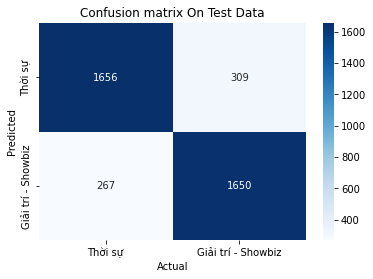

In [227]:
new_cm = pd.DataFrame(cm , index = ['Thời sự','Giải trí - Showbiz'] , columns = ['Thời sự','Giải trí - Showbiz'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Thời sự','Giải trí - Showbiz'], yticklabels = ['Thời sự','Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()

GAUSSIAN NAIVE BAYES

In [228]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [229]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1570  395]
 [ 254 1663]]


In [230]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1965
           1       0.81      0.87      0.84      1917

    accuracy                           0.83      3882
   macro avg       0.83      0.83      0.83      3882
weighted avg       0.83      0.83      0.83      3882



In [231]:
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuracy: 83.28


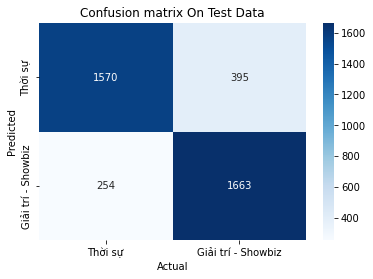

In [232]:
new_cm = pd.DataFrame(cm , index = ['Thời sự','Giải trí - Showbiz'] , columns = ['Thời sự','Giải trí - Showbiz'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Thời sự','Giải trí - Showbiz'], yticklabels = ['Thời sự','Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()

BERNOULLI NAIVE BAYES

In [233]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

BernoulliNB()

In [234]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1557  408]
 [ 267 1650]]


In [235]:
print(classification_report(y_test, y_pred))
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1965
           1       0.80      0.86      0.83      1917

    accuracy                           0.83      3882
   macro avg       0.83      0.83      0.83      3882
weighted avg       0.83      0.83      0.83      3882

Accuracy: 82.61


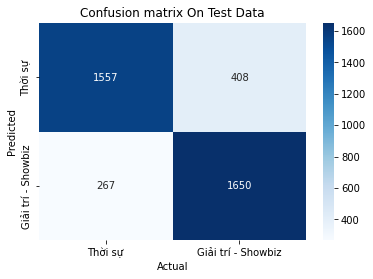

In [236]:
new_cm = pd.DataFrame(cm , index = ['Thời sự','Giải trí - Showbiz'] , columns = ['Thời sự','Giải trí - Showbiz'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Thời sự','Giải trí - Showbiz'], yticklabels = ['Thời sự','Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()

SUPPORT VECTOR MACHINES

In [237]:
from sklearn.svm import NuSVC

classifier = NuSVC(max_iter=200)
classifier.fit(X_train, y_train)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


NuSVC(max_iter=200)

In [238]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1377  588]
 [ 173 1744]]


In [239]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1965
           1       0.75      0.91      0.82      1917

    accuracy                           0.80      3882
   macro avg       0.82      0.81      0.80      3882
weighted avg       0.82      0.80      0.80      3882



In [240]:
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuracy: 80.4


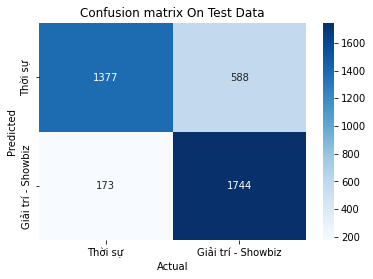

In [241]:
new_cm = pd.DataFrame(cm , index = ['Thời sự','Giải trí - Showbiz'] , columns = ['Thời sự','Giải trí - Showbiz'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Thời sự','Giải trí - Showbiz'], yticklabels = ['Thời sự','Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()